<a href="https://colab.research.google.com/github/INFINITY-RUBER/Curso_Deep_Learning_Con_TernsorFlow_Machine-Learning_e_IA-/blob/master/scripts/tema05/05-svm-multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow==1.14

# SVM Multi Clase

- Una contra una: si tenemos $k$ categorías, entonces hay que crear ${k\choose 2} = \frac{k!}{(k-2)!2!}$ clasificadores

- Una contra todas: si tenemos $k$ categorías, hay que crear exactamente $k$ clasificadores, uno o no uno; dos o no dos, tres o no tres,... k o no k.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets

In [0]:
session = tf.Session()

In [0]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y == 0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y == 1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y == 2 else -1 for y in iris.target])

class1_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if iris.target[i]==2]

y_vals = np.array([y_vals1, y_vals2, y_vals3])

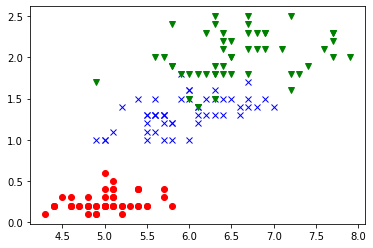

In [5]:
plt.plot(class1_x, class1_y, 'ro', label = "Setosa")
plt.plot(class2_x, class2_y, 'bx', label = "Versicolor")
plt.plot(class3_x, class3_y, 'gv', label = "Virginica")
plt.show()

In [0]:
batch_size = 150

x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape = [None, 2], dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

In [0]:
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data),1)
dist = tf.reshape(dist, [-1,1])
sq_dist = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dist)))

Antes podíamos hacer $x^T\cdot x$

In [0]:
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, batch_size, 1])
    return tf.matmul(v2, v1)

In [0]:
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b),b)
y_target_cross = reshape_matmul(y_target)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)), [1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

In [0]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1,1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))),
                      tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In [0]:
prediction_output = tf.matmul(tf.multiply(y_target, b), pred_kernel)
prediction = tf.argmax(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output, 1), 1), 0)

In [0]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target,0)),tf.float32))

In [0]:
my_optim = tf.train.GradientDescentOptimizer(0.01)
train_step = my_optim.minimize(loss)
init = tf.global_variables_initializer()
session.run(init)

In [14]:
loss_vect = []
batch_acc = []
for i in range(200):
    rand_idx = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = y_vals[:,rand_idx]
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vect.append(temp_loss)
    
    acc_temp = session.run(accuracy, feed_dict={x_data:rand_x, y_target: rand_y, prediction_grid: rand_x})
    batch_acc.append(acc_temp)
    
    if(i+1)%25==0:
        print("Paso #"+str(i+1)+", Pérdida: "+str(temp_loss)+", Precisión: "+str(acc_temp))

Paso #25, Pérdida: 31.733507, Precisión: 0.62666667
Paso #50, Pérdida: -19.530224, Precisión: 0.74666667
Paso #75, Pérdida: -31.9936, Precisión: 0.99333334
Paso #100, Pérdida: -27.417383, Precisión: 0.9266667
Paso #125, Pérdida: -32.461178, Precisión: 0.9
Paso #150, Pérdida: -36.410027, Precisión: 0.96
Paso #175, Pérdida: -32.7278, Precisión: 0.96666664
Paso #200, Pérdida: -32.11399, Precisión: 0.9533333


In [0]:
x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

grid_predictions = session.run(prediction, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

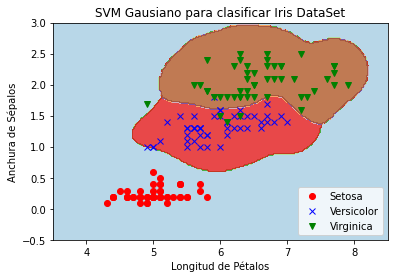

In [16]:
plt.contourf(xx,yy, grid_predictions, cmap = plt.cm.Paired, alpha = 0.8)
plt.plot(class1_x, class1_y, 'ro', label = "Setosa")
plt.plot(class2_x, class2_y, 'bx', label = "Versicolor")
plt.plot(class3_x, class3_y, 'gv', label = "Virginica")
plt.title("SVM Gausiano para clasificar Iris DataSet")
plt.xlabel("Longitud de Pétalos")
plt.ylabel("Anchura de Sépalos")
plt.legend(loc="lower right")
plt.xlim([3.5,8.5])
plt.ylim([-0.5, 3.0])
plt.show()

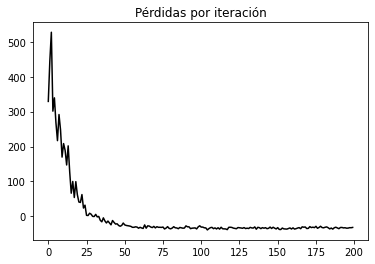

In [17]:
plt.plot(loss_vect, 'k-')
plt.title("Pérdidas por iteración")
plt.show()

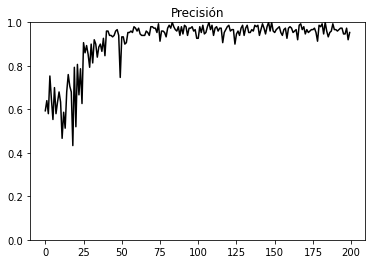

In [18]:
plt.plot(batch_acc, 'k-')
plt.title("Precisión")
plt.ylim([0,1])
plt.show()